In [ ]:
'''
Installing necessary Python libraries and system packages:

1. Installing the pyshark and pandas Python libraries.
2. Installing the nest_asyncio library, which allows nested use of asyncio event loops.
3. Updating the package list on the system.
4. Installing the tshark network protocol analyzer.
'''

!pip install pyshark pandas
!pip install nest_asyncio
!apt-get update
!apt-get install -y tshark

In [2]:
# importing the packages
import pyshark
import pandas as pd
import nest_asyncio
import asyncio
import matplotlib.pyplot as plt

# Mounting to Google Drive for accessing and saving data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
'''
Performing necessary setup steps for processing a PCAP file:

1. Enabling nested asyncio to allow nested use of asyncio event loops.
2. Defining the path to the PCAP file stored in the drive.
'''
nest_asyncio.apply()
pcap_file_path = '/content/drive/My Drive/pcap/client.pcap'

In [4]:
# Initializing lists to store extracted data
timestamps = []
packet_sizes = []
src_ips = []
dst_ips = []
protocols = []
src_ports = []
dst_ports = []

In [5]:
'''
Capturing packets and extracting data:

1. Capturing packets from the PCAP file using pyshark.
2. Iterating over each packet and extract the following information:
    - Timestamp
    - Packet size
    - Source IP address
    - Destination IP address
    - Protocol used
    - Source and destination ports (for TCP and UDP protocols)
3. Appending the extracted information to their respective lists.
4. Closing the packet capture file.
'''

cap = pyshark.FileCapture(pcap_file_path)
for packet in cap:
    timestamps.append(packet.sniff_time.timestamp())
    packet_sizes.append(int(packet.length))
    src_ips.append(packet.ip.src)
    dst_ips.append(packet.ip.dst)
    protocols.append(packet.highest_layer)
    if 'TCP' in packet:
        src_ports.append(packet.tcp.srcport)
        dst_ports.append(packet.tcp.dstport)
    elif 'UDP' in packet:
        src_ports.append(packet.udp.srcport)
        dst_ports.append(packet.udp.dstport)
    else:
        src_ports.append(None)
        dst_ports.append(None)
cap.close()

In [6]:
# Creating a dataframe with the extracted data
df = pd.DataFrame({
    'timestamp': timestamps,
    'packet_size': packet_sizes,
    'src_ip': src_ips,
    'dst_ip': dst_ips,
    'protocol': protocols,
    'src_port': src_ports,
    'dst_port': dst_ports
})

In [7]:
# Converting timestamps to integer seconds
df['time_sec'] = df['timestamp'].astype(int)

# Calculating packets per second
packets_per_sec = df.groupby('time_sec').size().reset_index(name='packets_per_sec')

# Merging the packets per second data with the original DataFrame
df = pd.merge(df, packets_per_sec, on='time_sec', how='left')

In [8]:
'''
1. Saving the DataFrame to a CSV file in the specified path on the drive.
2. Displaying the first 100 rows of the DataFrame for inspection.
'''
csv_file_path = '/content/drive/My Drive/pcap/packet_analysis.csv'
df.to_csv(csv_file_path, index=False)

df.head(100)

,timestamp,packet_size,src_ip,dst_ip,protocol,src_port,dst_port,time_sec,packets_per_sec
0,1.721900e+09,74,10.0.0.1,10.0.0.2,TCP,1935,35012,1721899983,30
1,1.721900e+09,66,10.0.0.1,10.0.0.2,TCP,1935,35012,1721899983,30
2,1.721900e+09,66,10.0.0.1,10.0.0.2,TCP,1935,35012,1721899983,30
3,1.721900e+09,1514,10.0.0.1,10.0.0.2,TCP,1935,35012,1721899983,30
4,1.721900e+09,155,10.0.0.1,10.0.0.2,TCP,1935,35012,1721899983,30
...,...,...,...,...,...,...,...,...,...
95,1.721900e+09,291,10.0.0.1,10.0.0.2,RTMPT,1935,35012,1721899986,38
96,1.721900e+09,260,10.0.0.1,10.0.0.2,RTMPT,1935,35012,1721899986,38
97,1.721900e+09,281,10.0.0.1,10.0.0.2,RTMPT,1935,35012,1721899986,38
98,1.721900e+09,281,10.0.0.1,10.0.0.2,RTMPT,1935,35012,1721899986,38


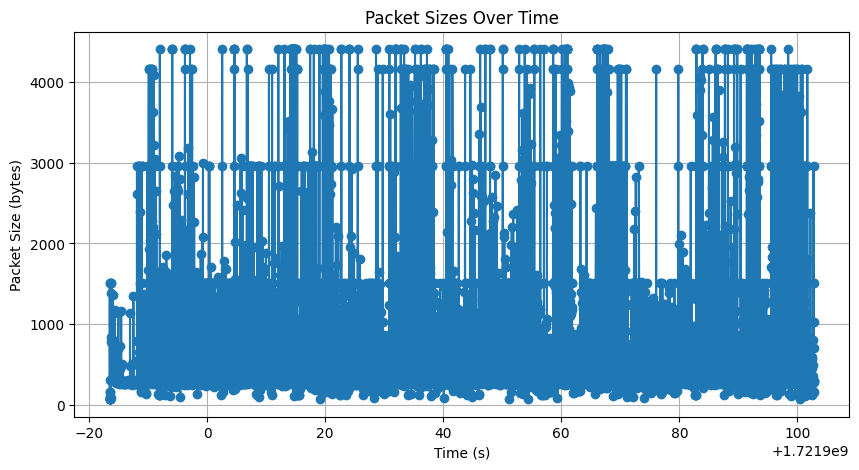

In [9]:
'''
Plotting packet sizes over time:

Labels: x-axis as "Time (s)" and the y-axis as "Packet Size (bytes)".
Displaying the plot.
'''

plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['packet_size'], marker='o')
plt.title('Packet Sizes Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Packet Size (bytes)')
plt.grid(True)
plt.show()


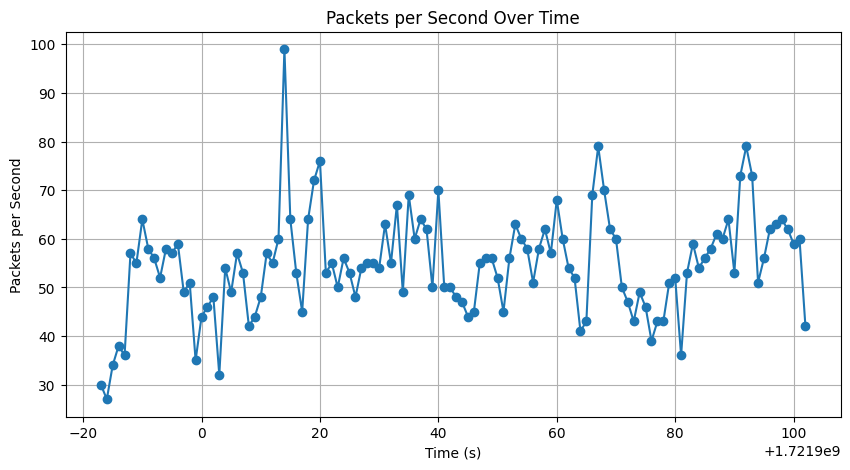

In [10]:
'''
Plotting transferred packets per second over time:

Labels: x-axis as "Time (s)" and the y-axis as "Packets per Second".
Displaying the plot.
'''

plt.figure(figsize=(10, 5))
plt.plot(packets_per_sec['time_sec'], packets_per_sec['packets_per_sec'], marker='o')
plt.title('Packets per Second Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Packets per Second')
plt.grid(True)
plt.show()


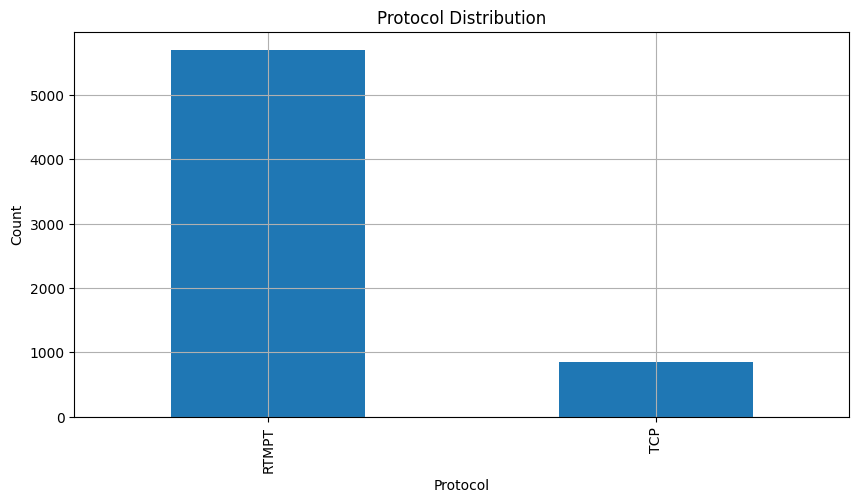

In [11]:
'''
Analyzing protocol distribution:

1. Counting the occurrences of each protocol in the DataFrame.
2. Creating a bar plot to visualize the distribution of protocols.
5. Labels: x-axis as "Protocol" and the y-axis as "Count".
7. Displaying the plot.
'''

protocol_counts = df['protocol'].value_counts()
protocol_counts.plot(kind='bar', figsize=(10, 5), title='Protocol Distribution')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.grid(True)
plt.show()
